In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os


# Load the dataset from the Excel file
df = pd.read_excel('C:/Users/hamzs/Downloads/AirQuality.xlsx')

# Check the initial shape (rows, columns) and first couple of rows
print("Initial data shape:", df.shape)
print(df.head(2))


Initial data shape: (9357, 15)
        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0 2004-03-10  18:00:00     2.6      1360.00       150  11.881723   
1 2004-03-10  19:00:00     2.0      1292.25       112   9.397165   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0        1045.50    166.0       1056.25    113.0       1692.00      1267.50   
1         954.75    103.0       1173.75     92.0       1558.75       972.25   

      T         RH        AH  
0  13.6  48.875001  0.757754  
1  13.3  47.700000  0.725487  


In [79]:

# Replace all occurrences of -200 with NaN to mark them as missing
df.replace(-200, np.nan, inplace=True)
df.drop(columns=['NMHC(GT)'], inplace=True)  # Too many missing
df.dropna(inplace=True)
print(df.isna().sum())


Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


In [81]:
# Combine Date and Time into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

# Verify the new Datetime column
print(df['Datetime'].head(3))
print("Datatype of new column:", df['Datetime'].dtype)

0   2004-03-10 18:00:00
1   2004-03-10 19:00:00
2   2004-03-10 20:00:00
Name: Datetime, dtype: datetime64[ns]
Datatype of new column: datetime64[ns]


In [83]:
# Create new features from the Datetime column
df['Hour'] = df['Datetime'].dt.hour                # Hour of day (0-23)
df['DayOfWeek'] = df['Datetime'].dt.day_name()     # Day of week as full name
df['Month'] = df['Datetime'].dt.month              # Month as number (1-12)

# Check the new feature columns for the first row as an example
print(df.loc[0, ['Datetime', 'Hour', 'DayOfWeek', 'Month']])


Datetime     2004-03-10 18:00:00
Hour                          18
DayOfWeek              Wednesday
Month                          3
Name: 0, dtype: object


In [85]:
# Check missing values after feature engineering
print(df.isna().sum())


Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
Datetime         0
Hour             0
DayOfWeek        0
Month            0
dtype: int64


In [87]:
# Dataset shape after adding new features
print("Final data shape:", df.shape)

# Summary statistics for numeric columns
print(df.describe())


Final data shape: (6941, 18)
                                Date       CO(GT)  PT08.S1(CO)     C6H6(GT)  \
count                           6941  6941.000000  6941.000000  6941.000000   
mean   2004-09-27 13:44:27.454257280     2.182467  1119.786222    10.554411   
min              2004-03-10 00:00:00     0.100000   647.250000     0.181525   
25%              2004-06-15 00:00:00     1.100000   956.250000     4.927071   
50%              2004-10-08 00:00:00     1.900000  1084.750000     8.788282   
75%              2005-01-12 00:00:00     2.900000  1254.000000    14.579057   
max              2005-04-04 00:00:00    11.900000  2039.750000    63.741476   
std                              NaN     1.441158   218.739106     7.465170   

       PT08.S2(NMHC)      NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  \
count    6941.000000  6941.000000   6941.000000  6941.000000   6941.000000   
mean      958.421925   250.656476    816.771659   113.858608   1452.528598   
min       390.250000     

In [89]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

for col in ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S5(O3)']:
    df = remove_outliers_iqr(df, col)

In [91]:
os.makedirs("figures", exist_ok=True)
pollutants = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S5(O3)']

for col in pollutants:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[col], kde=True, bins=30, ax=axes[0])
    axes[0].set_title(f'Distribution of {col}')
    
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.savefig(f"figures/pollutant_distribution_{col.replace('/', '').replace('(', '').replace(')', '')}.png", dpi=300)
    plt.close()

In [93]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(pollutants, 1):
    plt.subplot(3, 2, i)
    sns.lineplot(data=df, x='Hour', y=col, estimator='mean')
    plt.title(f'Hourly Average of {col}')
    plt.xlabel('Hour of Day')
    plt.ylabel(col)
plt.tight_layout()
plt.savefig("figures/hourly_trends.png", dpi=300)
plt.close()

In [95]:
# Weekly
# Ensure the days are treated as ordered categorical values
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=ordered_days, ordered=True)

# Now plot
plt.figure(figsize=(14, 6))
for i, col in enumerate(pollutants, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(data=df, x='DayOfWeek', y=col, estimator='mean')
    plt.title(f'Weekly Average of {col}')
    plt.xlabel("Day of Week")
    plt.ylabel(col)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/weekday_trends.png", dpi=300)
plt.close()


# Monthly
plt.figure(figsize=(15, 10))
for i, col in enumerate(pollutants, 1):
    plt.subplot(3, 2, i)
    sns.lineplot(data=df, x='Month', y=col, estimator='mean')
    plt.title(f'Monthly Average of {col}')
    plt.xlabel('Month')
    plt.ylabel(col)
plt.tight_layout()
plt.savefig("figures/monthly_trends.png", dpi=300)
plt.close()


In [103]:
# Select only numeric columns (exclude object/datetime/time types)
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.savefig("figures/correlation_heatmap.png", dpi=300)
plt.close()

In [99]:
# Compute and display the correlation matrix
corr_matrix = df.corr(numeric_only=True).round(2)

# Print sorted correlations with temperature and RH
print("Correlations with Temperature (T):")
print(corr_matrix['T'].sort_values(ascending=False))
print("\nCorrelations with Relative Humidity (RH):")
print(corr_matrix['RH'].sort_values(ascending=False))
print("\nCorrelations with PT08.S5(O3):")
print(corr_matrix['PT08.S5(O3)'].sort_values(ascending=False))

# If needed, save the whole matrix
corr_matrix.to_csv("correlation_matrix.csv")

Correlations with Temperature (T):
T                1.00
AH               0.65
PT08.S4(NO2)     0.64
PT08.S2(NMHC)    0.35
C6H6(GT)         0.33
Month            0.29
Hour             0.21
CO(GT)           0.13
PT08.S1(CO)      0.12
PT08.S5(O3)      0.04
NO2(GT)         -0.14
PT08.S3(NOx)    -0.18
NOx(GT)         -0.24
RH              -0.56
Name: T, dtype: float64

Correlations with Relative Humidity (RH):
RH               1.00
AH               0.19
NOx(GT)          0.17
PT08.S5(O3)      0.12
PT08.S1(CO)      0.11
Month            0.08
CO(GT)          -0.04
PT08.S3(NOx)    -0.06
PT08.S4(NO2)    -0.06
C6H6(GT)        -0.14
PT08.S2(NMHC)   -0.15
NO2(GT)         -0.17
Hour            -0.30
T               -0.56
Name: RH, dtype: float64

Correlations with PT08.S5(O3):
PT08.S5(O3)      1.00
PT08.S1(CO)      0.87
PT08.S2(NMHC)    0.85
C6H6(GT)         0.83
CO(GT)           0.81
NOx(GT)          0.72
NO2(GT)          0.64
PT08.S4(NO2)     0.55
Hour             0.19
AH               0.14
RH   

In [29]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x='DayOfWeek', y='CO(GT)')
plt.title("CO Levels by Weekday")
plt.savefig("figures/weekday_boxplots.png", dpi=300)
plt.close()

In [31]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x='T', y='PT08.S5(O3)', data=df)
plt.title("O3 vs Temperature")

plt.subplot(1, 3, 2)
sns.scatterplot(x='RH', y='CO(GT)', data=df)
plt.title("CO vs Relative Humidity")

plt.subplot(1, 3, 3)
sns.scatterplot(x='RH', y='NOx(GT)', data=df)
plt.title("NOx vs Relative Humidity")

plt.tight_layout()
plt.savefig("figures/temp_rh_co_heatmap.png", dpi=300)
plt.close()


In [33]:
# Sensor-to-GroundTruth Ratio Over Time
df['CO_Ratio'] = df['PT08.S1(CO)'] / df['CO(GT)']
df['NOx_Ratio'] = df['PT08.S3(NOx)'] / df['NOx(GT)']

plt.figure(figsize=(12, 5))
sns.lineplot(x='Datetime', y='CO_Ratio', data=df, label='CO Sensor Ratio')
sns.lineplot(x='Datetime', y='NOx_Ratio', data=df, label='NOx Sensor Ratio')
plt.title('Sensor-to-GroundTruth Ratio Over Time')
plt.ylabel('Sensor / Ground Truth')
plt.xlabel('Datetime')
plt.legend()
plt.tight_layout()
plt.savefig('figures/sensor_to_gt_ratio.png')
plt.close()

In [35]:
# CO by Temperature and Humidity Bins (Heatmap)
df['T_bin'] = pd.cut(df['T'], bins=10)
df['RH_bin'] = pd.cut(df['RH'], bins=10)
pivot = df.pivot_table(index='T_bin', columns='RH_bin', values='CO(GT)', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, cmap='viridis')
plt.title("CO Concentration by Temperature and Humidity Bins")
plt.tight_layout()
plt.savefig('figures/co_temp_rh_heatmap.png')  
plt.close()

C:\Users\hamzs\AppData\Local\Temp\ipykernel_48672\2224889741.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index='T_bin', columns='RH_bin', values='CO(GT)', aggfunc='mean')


In [37]:
# Boxplot of CO(GT) by Temperature Range
df['TempBin'] = pd.cut(df['T'], bins=[-5, 0, 5, 10, 15, 20, 25, 30, 40])

plt.figure(figsize=(10, 5))
sns.boxplot(x='TempBin', y='CO(GT)', data=df)
plt.title('CO(GT) Distribution by Temperature Bins')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('CO(GT)')
plt.xticks(rotation=45)
plt.savefig('figures/co_temp_boxplot.png')
plt.close()

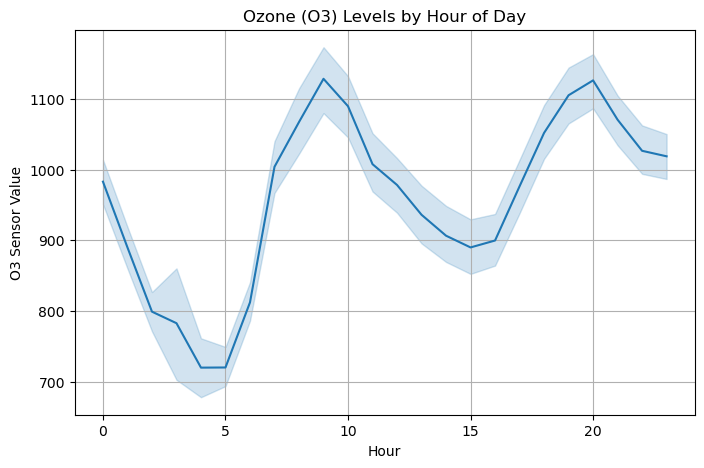

In [39]:
plt.figure(figsize=(8, 5))
sns.lineplot(x='Hour', y='PT08.S5(O3)', data=df, estimator='mean')
plt.title('Ozone (O3) Levels by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('O3 Sensor Value')
plt.grid(True)
plt.show()


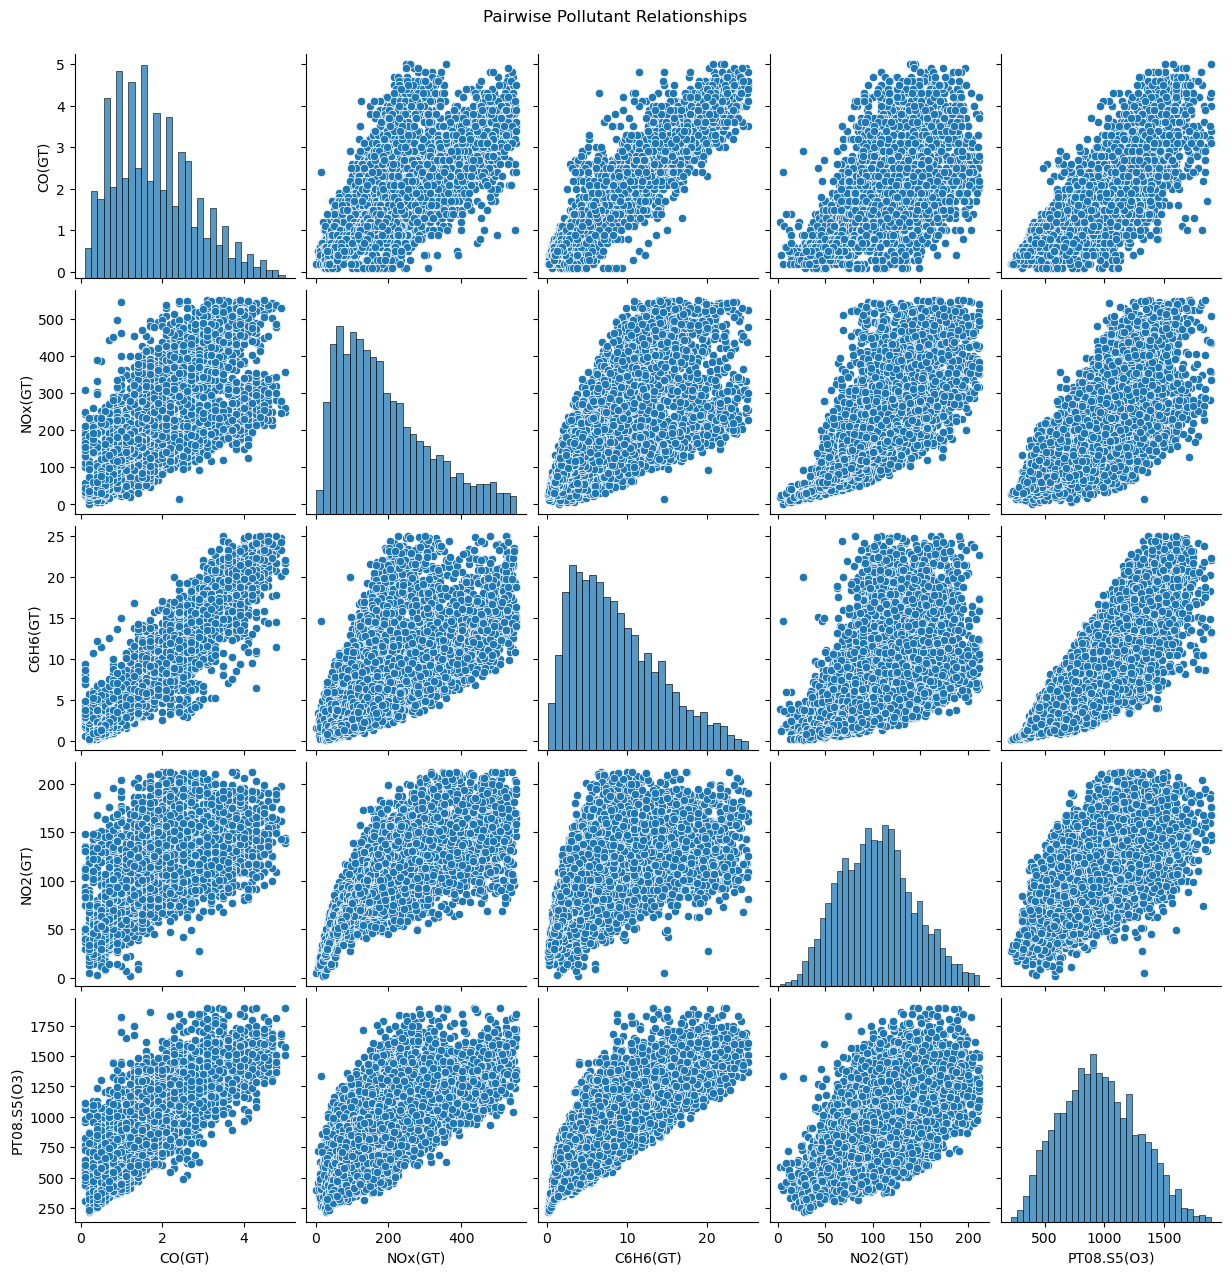

In [41]:
sns.pairplot(df[['CO(GT)', 'NOx(GT)', 'C6H6(GT)', 'NO2(GT)', 'PT08.S5(O3)']])
plt.suptitle('Pairwise Pollutant Relationships', y=1.02)
plt.show()


In [43]:
from scipy.stats import pearsonr

# CO Sensor Accuracy
r1, p1 = pearsonr(df['PT08.S1(CO)'], df['CO(GT)'])
# NOx Sensor Anomaly
r2, p2 = pearsonr(df['PT08.S3(NOx)'], df['NOx(GT)'])

print(f"Sensor PT08.S1(CO) vs CO(GT): r = {r1:.2f}, p = {p1:.4f}")
print(f"Sensor PT08.S3(NOx) vs NOx(GT): r = {r2:.2f}, p = {p2:.4f}")


Sensor PT08.S1(CO) vs CO(GT): r = 0.83, p = 0.0000
Sensor PT08.S3(NOx) vs NOx(GT): r = -0.63, p = 0.0000


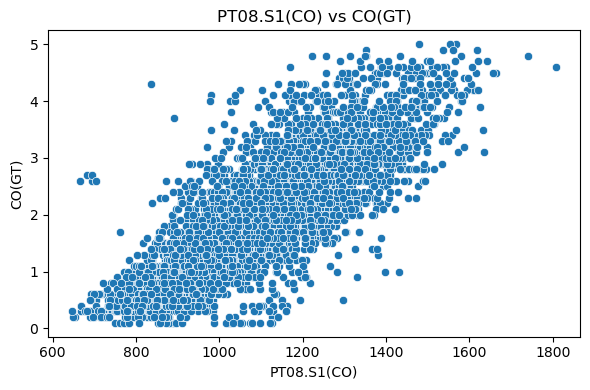

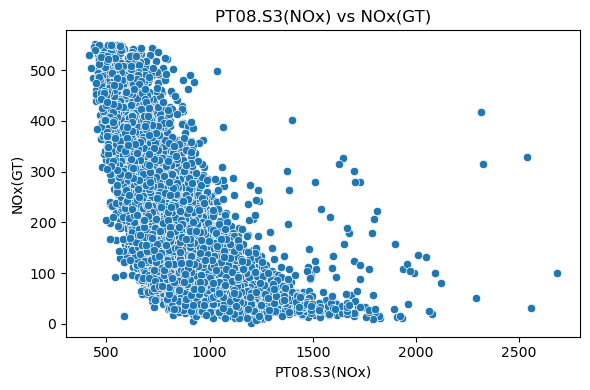

In [45]:
sensor_vs_gt = [
    ('PT08.S1(CO)', 'CO(GT)'),
    ('PT08.S3(NOx)', 'NOx(GT)')
]

for sensor, truth in sensor_vs_gt:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=sensor, y=truth, data=df)
    plt.title(f'{sensor} vs {truth}')
    plt.tight_layout()
    plt.show()


In [47]:
from scipy.stats import ttest_ind

# Add numeric weekday column
df['DayOfWeek'] = df['Datetime'].dt.weekday

# Define rush hour: 7–9 AM and 5–7 PM on weekdays
df['IsRushHour'] = df.apply(
    lambda row: (row['Hour'] in [7, 8, 17, 18]) and (row['DayOfWeek'] < 5), axis=1
)

# t-test for CO(GT)
rush = df[df['IsRushHour']]['CO(GT)']
non_rush = df[~df['IsRushHour']]['CO(GT)']
t_stat_co, p_val_co = ttest_ind(rush, non_rush, equal_var=False)

# t-test for NOx(GT)
rush_nox = df[df['IsRushHour']]['NOx(GT)']
non_rush_nox = df[~df['IsRushHour']]['NOx(GT)']
t_stat_nox, p_val_nox = ttest_ind(rush_nox, non_rush_nox, equal_var=False)

print(f"H1 - CO(GT): t = {t_stat_co:.2f}, p = {p_val_co:.4f}")
print(f"H1 - NOx(GT): t = {t_stat_nox:.2f}, p = {p_val_nox:.4f}")


H1 - CO(GT): t = 17.46, p = 0.0000
H1 - NOx(GT): t = 14.05, p = 0.0000


In [49]:
# Define winter months (Dec, Jan, Feb)
df['IsWinter'] = df['Month'].isin([12, 1, 2])

# CO(GT)
winter = df[df['IsWinter']]['CO(GT)']
non_winter = df[~df['IsWinter']]['CO(GT)']
t_stat_winter_co, p_val_winter_co = ttest_ind(winter, non_winter, equal_var=False)

# NOx(GT)
winter_nox = df[df['IsWinter']]['NOx(GT)']
non_winter_nox = df[~df['IsWinter']]['NOx(GT)']
t_stat_winter_nox, p_val_winter_nox = ttest_ind(winter_nox, non_winter_nox, equal_var=False)

print(f"H2 - CO(GT): t = {t_stat_winter_co:.2f}, p = {p_val_winter_co:.4f}")
print(f"H2 - NOx(GT): t = {t_stat_winter_nox:.2f}, p = {p_val_winter_nox:.4f}")


H2 - CO(GT): t = -3.79, p = 0.0002
H2 - NOx(GT): t = 23.32, p = 0.0000


In [51]:
from scipy.stats import pearsonr

# O3 ~ Temperature
r_ozone_temp, p_ozone_temp = pearsonr(df['PT08.S5(O3)'], df['T'])
# CO ~ RH
r_co_rh, p_co_rh = pearsonr(df['CO(GT)'], df['RH'])
# NOx ~ RH
r_nox_rh, p_nox_rh = pearsonr(df['NOx(GT)'], df['RH'])

print(f"H3 - O3 vs T: r = {r_ozone_temp:.2f}, p = {p_ozone_temp:.4f}")
print(f"H3 - CO vs RH: r = {r_co_rh:.2f}, p = {p_co_rh:.4f}")
print(f"H3 - NOx vs RH: r = {r_nox_rh:.2f}, p = {p_nox_rh:.4f}")


H3 - O3 vs T: r = 0.06, p = 0.0000
H3 - CO vs RH: r = -0.07, p = 0.0000
H3 - NOx vs RH: r = 0.15, p = 0.0000


In [53]:
from scipy.stats import f_oneway

groups = [group['C6H6(GT)'].values for _, group in df.groupby('DayOfWeek')]
f_stat_benzene, p_val_benzene = f_oneway(*groups)

print(f"H4 - Benzene (C6H6) ANOVA: F = {f_stat_benzene:.2f}, p = {p_val_benzene:.4f}")


H4 - Benzene (C6H6) ANOVA: F = 86.77, p = 0.0000


In [55]:
# CO
r_co_sensor, p_co_sensor = pearsonr(df['PT08.S1(CO)'], df['CO(GT)'])
# NOx
r_nox_sensor, p_nox_sensor = pearsonr(df['PT08.S3(NOx)'], df['NOx(GT)'])

print(f"H5 - PT08.S1(CO) vs CO(GT): r = {r_co_sensor:.2f}, p = {p_co_sensor:.4f}")
print(f"H5 - PT08.S3(NOx) vs NOx(GT): r = {r_nox_sensor:.2f}, p = {p_nox_sensor:.4f}")


H5 - PT08.S1(CO) vs CO(GT): r = 0.83, p = 0.0000
H5 - PT08.S3(NOx) vs NOx(GT): r = -0.63, p = 0.0000


In [57]:
from scipy.stats import pearsonr

# Sensor vs ground-truth for NOx
r_nox_sensor, p_nox_sensor = pearsonr(df['PT08.S3(NOx)'], df['NOx(GT)'])

print(f"H6 - PT08.S3(NOx) vs NOx(GT): r = {r_nox_sensor:.2f}, p = {p_nox_sensor:.4f}")


H6 - PT08.S3(NOx) vs NOx(GT): r = -0.63, p = 0.0000


In [59]:
print(df["DayOfWeek"].describe)

<bound method NDFrame.describe of 0       2
1       2
2       2
3       2
4       2
       ..
9352    0
9353    0
9354    0
9355    0
9356    0
Name: DayOfWeek, Length: 6047, dtype: int32>


In [69]:
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['Time_of_Day'] = df['Hour'].apply(get_time_of_day)
pollutants = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)', 'PT08.S5(O3)']
for col in pollutants:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='Time_of_Day', y=col, order=['Morning', 'Afternoon', 'Evening', 'Night'])
    plt.title(f'{col} Distribution by Time of Day')
    plt.xlabel("Time of Day")
    plt.ylabel(col)
    plt.tight_layout()
    plt.savefig(F'figures/{col} Distrubution by Time of Day.png')  
    plt.close()

In [71]:
pollutant = 'CO(GT)' 
pivot = df.pivot_table(values=pollutant, index='DayOfWeek', columns='Time_of_Day', aggfunc='mean')
pivot = pivot[['Morning', 'Afternoon', 'Evening', 'Night']]
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5)
plt.title(f'Average {pollutant} Levels by Weekday and Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Weekday (0=Mon, 6=Sun)')
plt.tight_layout()
plt.savefig(F'figures/Average CO(GT) Levels by Weekday and Time of Day.png')  
plt.close()